The point of this notebook is to look at traces of different length and
experiment with different methods of diagnosing them, with the ultimate aim of seeing that they converge properly
Perhaps we will move on to evaluating the traces

In [6]:
import pymc_model as pm
import pymc
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import latin_hypercube as lh
from pymc.Matplot import plot
from pandas.plotting import autocorrelation_plot
import pygemfxns_ensemble_sampling as es
import v2_run_calibration_4Tushar as v2
import matplotlib.mlab as mlab
from jupyterthemes import jtplot
from scipy.stats import gaussian_kde
import scipy.stats as stats 

jtplot.style('grade3', fscale=1.3)
jtplot.figsize(x=18, y=10)

Upload different databases, each with its own sample length

In [2]:
s1 = pymc.database.pickle.load('test2length1000.pickle')
s3 = pymc.database.pickle.load('test2length3000.pickle')
s5 = pymc.database.pickle.load('test2length5000.pickle')
s10 = pymc.database.pickle.load('test2length10000.pickle')
s30 = pymc.database.pickle.load('test2length30000.pickle')
sample_dict = {'1000':s1, '3000':s3, '5000':s5, '10000':s10, '30000':s30}
params = ['massbal', 'tempchange', 'ddfsnow', 'precfactor']

Start by comaring the means and standard deviations of each database

In [3]:
for key, value in sample_dict.items():
    mean = np.mean(value.trace('mass_bal')[:])
    std = np.std(value.trace('mass_bal')[:])
    print(key + ' samples:', mean, std)

1000 samples: -0.562115960506 0.225390596859
3000 samples: -0.541571378174 0.242510953646
5000 samples: -0.54631709463 0.238941163444
10000 samples: -0.531816067932 0.23496921524
30000 samples: -0.539429164038 0.236528453722


Use the built in pymc function to look at summary statistics for each variable. 
I was told that MC error should be less than 1% of mean, which is not actually 
a condition that is met even in the 10000 sample

Now we look at a sampling of parameter sets over the space of the Markov chain; ie, we look at the mass balance value that each parameter set leads to, we sort the mass balance values, section them into chunks of equal probability, and randomly sample from each chunk. This gives us a 'stratified' sampling that covers the space of mass balance values but does so with the same mean and standard deviation that the entire chain does. 

In [5]:
for key, value in sample_dict.items():
    tempchange = value.trace('tempchange')[:]
    precfactor = value.trace('precfactor')[:]
    ddfsnow = value.trace('ddfsnow')[:]
    massbal = value.trace('mass_bal')[:]
    result = lh.sample2(tempchange=tempchange, precfactor=precfactor,
                     ddfsnow=ddfsnow, massbal=massbal, samples=300)
    mean = np.mean(result['massbal'])
    std = np.std(result['massbal'])
    print(key + ' samples, mean:', mean, 'std:', std)

1000 samples, mean: -0.5621967638024394 std: 0.2253690063770066
3000 samples, mean: -0.5417365395885467 std: 0.24237730227976598
5000 samples, mean: -0.546621335550779 std: 0.23707697848716452
10000 samples, mean: -0.5319464494448797 std: 0.2345919100919115
30000 samples, mean: -0.5395731970783786 std: 0.2362750031162424


In [4]:
v2.get_glacier_data(3473)

(-0.54100000000000004, 0.24299999999999999, 1977)

Now we look at the traces of each variable (thinned down) in the samples of different samples to see whether they have achieved a 'grassy' state, which is what we would expect as the chain converges

In [6]:
for key, value in sample_dict.items():
    tempchange = value.trace('tempchange')[:]
    precfactor = value.trace('precfactor')[:]
    ddfsnow = value.trace('ddfsnow')[:]
    massbal = value.trace('mass_bal')[:]
    result = es.stratified_sample(tempchange=tempchange, precfactor=precfactor,
                     ddfsnow=ddfsnow, massbal=massbal, samples=300)
    mean = np.mean(result['massbal'])
    std = np.std(result['massbal'])
    #print(key + ' samples, mean:', mean, 'std:', std)
    print(std)

0.2265690257109855
0.24263655242139168
0.23927553382282604
0.23446281983641076
0.23567064334933363


In [11]:
for param in params:
    for key, value in sample_dict.items():
        tempchange = value.trace('tempchange')[:]
        precfactor = value.trace('precfactor')[:]
        ddfsnow = value.trace('ddfsnow')[:]
        massbal = value.trace('mass_bal')[:]
        result = es.stratified_sample(tempchange=tempchange, precfactor=precfactor,
                         ddfsnow=ddfsnow, massbal=massbal, samples=200)
        mean = np.mean(result[param])
        std = np.std(result[param])
        print(key + ' samples, ' + param + ', mean:', mean, 'std:', std)

1000 samples, massbal, mean: -0.5617374358438711 std: 0.22529741064046377
3000 samples, massbal, mean: -0.5414901046018428 std: 0.2409218127179519
5000 samples, massbal, mean: -0.5462292993167412 std: 0.23814594058557667
10000 samples, massbal, mean: -0.532387755829061 std: 0.23607454816698714
30000 samples, massbal, mean: -0.5397891755135792 std: 0.2350870039886342
1000 samples, tempchange, mean: -0.1277826314837209 std: 0.1853643083235552
3000 samples, tempchange, mean: -0.26030544400616 std: 0.8712747649827236
5000 samples, tempchange, mean: -0.2990169388632159 std: 0.7663425668108025
10000 samples, tempchange, mean: -0.33767593185370987 std: 0.7934658617754264
30000 samples, tempchange, mean: -0.30837498261940655 std: 0.845431231093801
1000 samples, ddfsnow, mean: 0.004014475837096369 std: 0.001407390800291772
3000 samples, ddfsnow, mean: 0.0043047359886866565 std: 0.001392365959981958
5000 samples, ddfsnow, mean: 0.004412018543428678 std: 0.0014683900004218294
10000 samples, ddfsn

/home/tushar/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  after removing the cwd from sys.path.


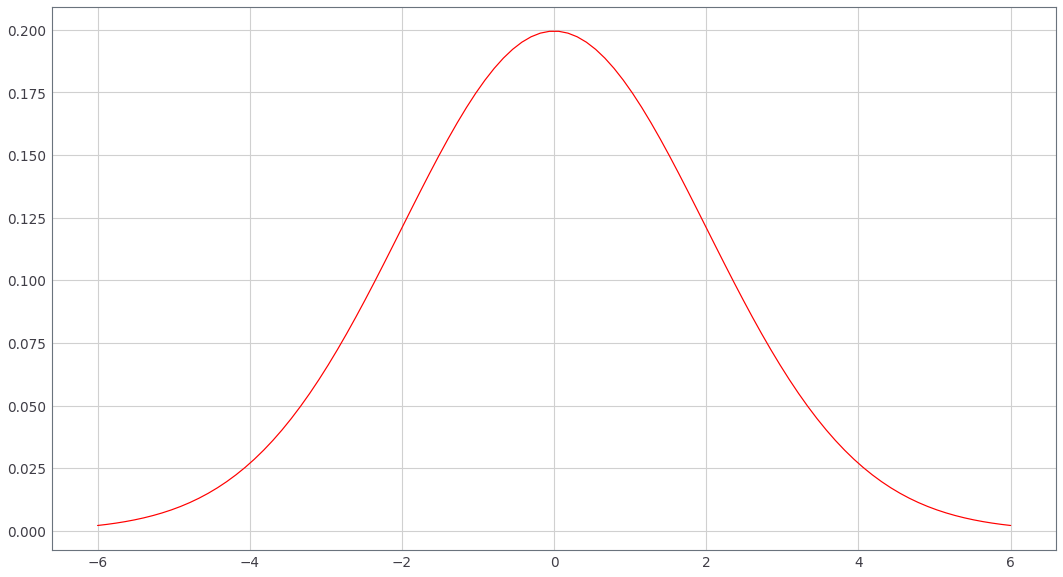

In [76]:
mu = 0
sigma = 2
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma), color='red')
plt.show()

/home/tushar/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


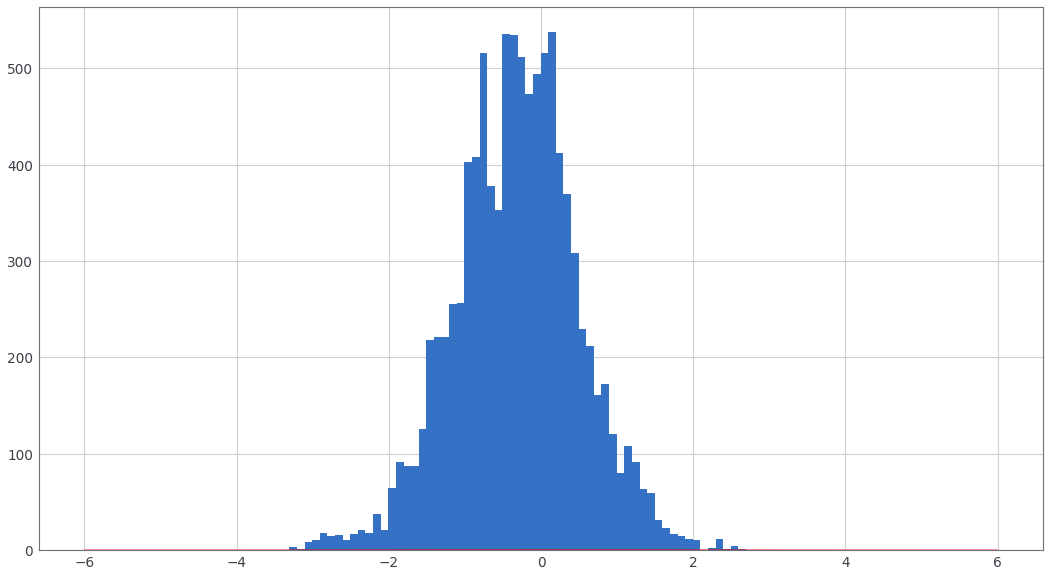

In [26]:
tempchange = s10.trace('tempchange')[:]
plt.hist(tempchange, bins=60)

In [46]:
# Generate a random sample.
a = s10.trace('tempchange')[:]

# Count the occurrences in the sample.
np.histogram(a, bins =10)

# p is the array of probabilities.
#p = b / float(b.sum())

#plt.bar(c, p)

(array([  57,  121,  477, 1574, 2724, 2944, 1451,  523,  109,   20]),
 array([-3.30708621, -2.7068703 , -2.10665439, -1.50643848, -0.90622257,
        -0.30600666,  0.29420924,  0.89442515,  1.49464106,  2.09485697,
         2.69507288]))

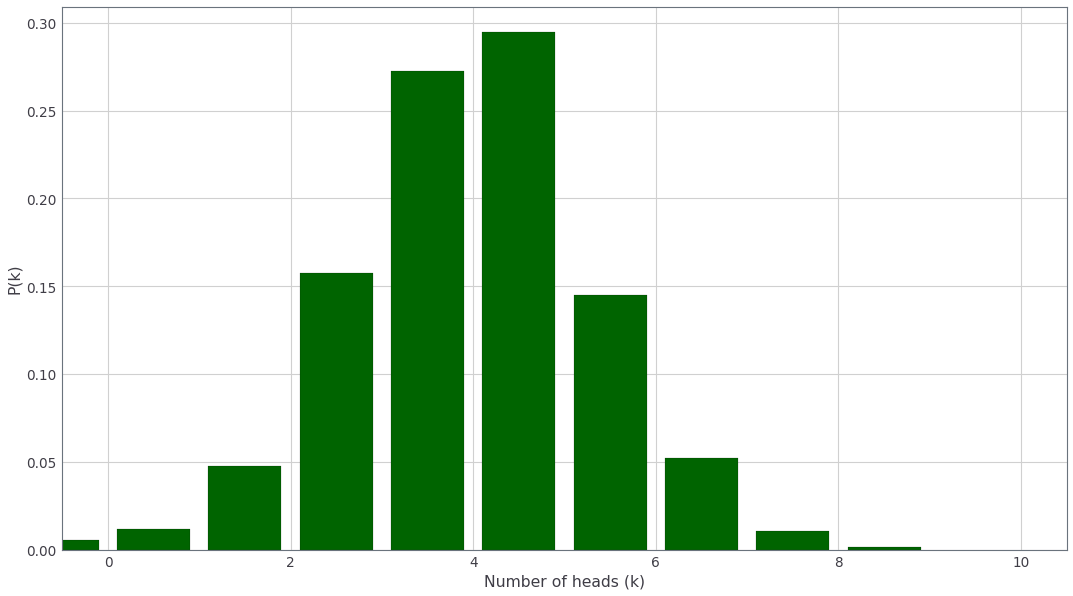

In [41]:
n = 10
num_samples = 10000

# Generate a random sample.
a = s10.trace('tempchange')[:]

# Count the occurrences in the sample.
b, c = np.histogram(a, bins =10)

# p is the array of probabilities.
p = b / float(b.sum())

plt.bar(np.arange(len(b)) - 0.5, p, width=0.8, facecolor='darkgreen', edgecolor='black')
plt.xlim(-0.5, n + 0.5)
plt.xlabel("Number of heads (k)")
plt.ylabel("P(k)")

plt.show()

/home/tushar/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


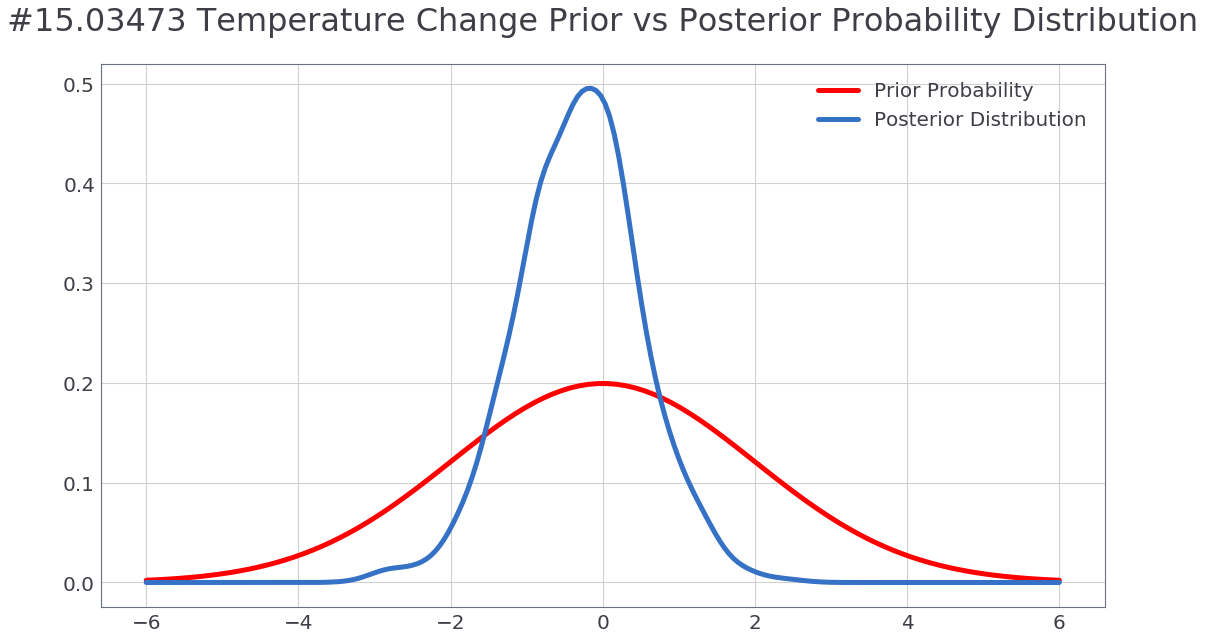

In [14]:
fig = plt.figure()

# plot the ideal pdf function
mu = 0
sigma = 2
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma), color='red', label = 'Prior Probability', linewidth=5)


# plot the actual density distribution
data = s10.trace('tempchange')[:]
density = gaussian_kde(data)
xs = np.linspace(-6, 6, 200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs), label = 'Posterior Distribution', linewidth=5)
plt.legend(loc='best', fontsize=20)

# niceties
plt.title('#15.03473 Temperature Change Prior vs Posterior Probability Distribution', fontsize = 32, y=1.05)
#plt.ylabel('Probability', fontsize =24 )
#plt.xlabel('Value', fontsize = 24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

fig.savefig('../probability_plots/03473tempchange.png')


/home/tushar/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


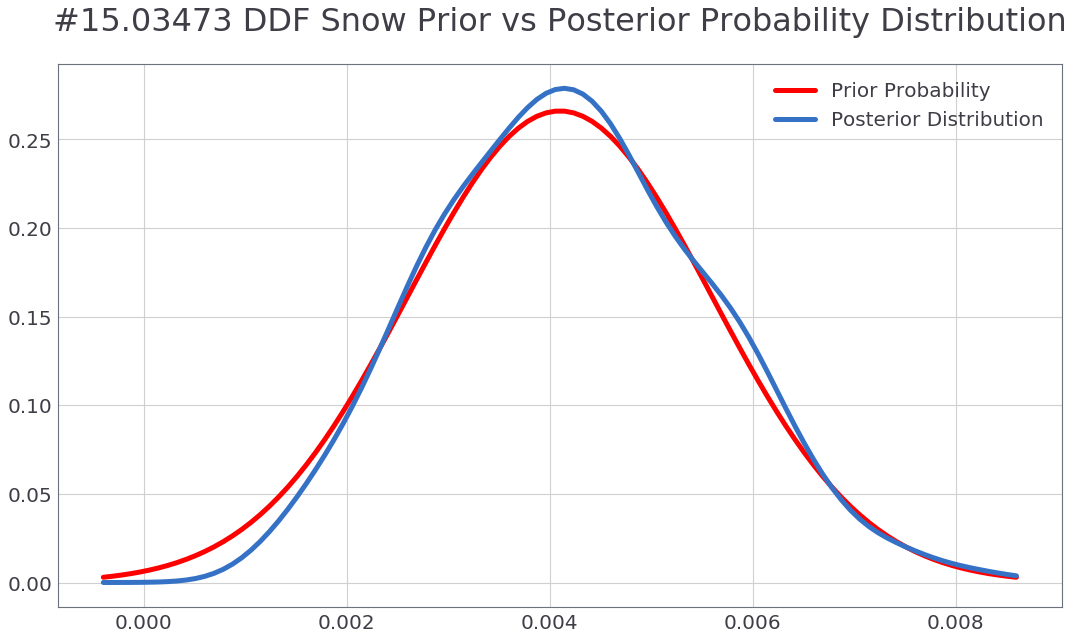

In [15]:
fig = plt.figure()

# plot the ideal pdf function
mu = 0.0041
sigma = 0.0015
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, mlab.normpdf(x, mu, sigma) /1000, color='red', label = 'Prior Probability', linewidth=5)

# plot the actual density distribution
data = s10.trace('ddfsnow')[:]
density = gaussian_kde(data)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(x, density(x) / 1000, label = 'Posterior Distribution', linewidth=5)
plt.legend(loc='best', fontsize=20)

# niceties
plt.title('#15.03473 DDF Snow Prior vs Posterior Probability Distribution', fontsize = 32, y=1.05)
#plt.ylabel('Probability', fontsize =24 )
#plt.xlabel('Value', fontsize = 24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

fig.savefig('../probability_plots/03473ddfsnow.png')

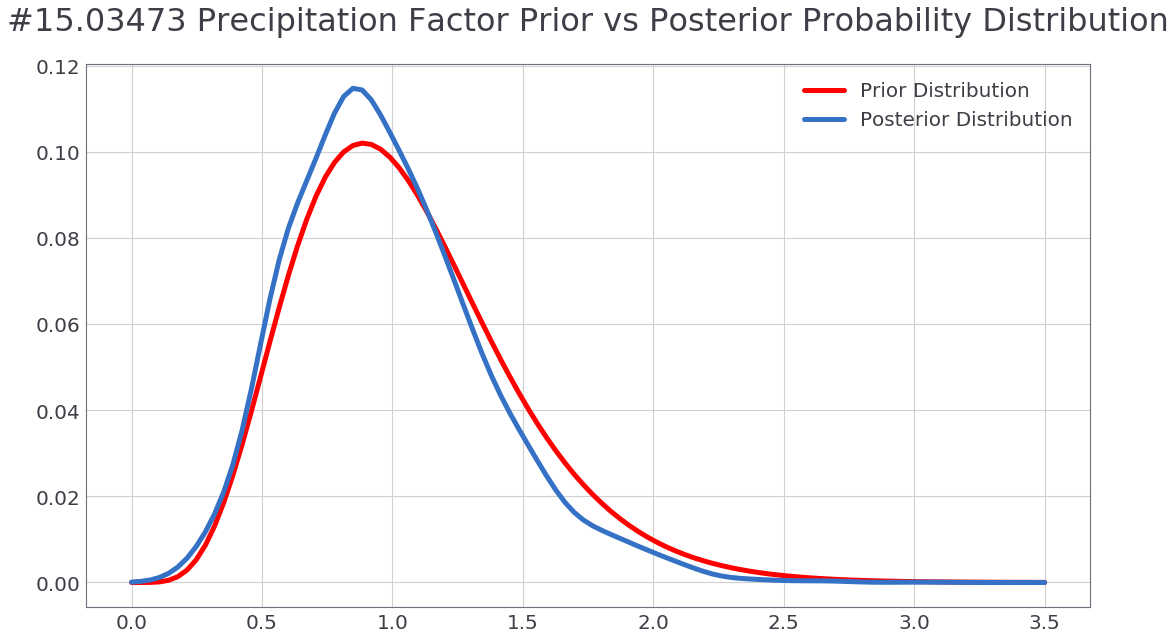

In [16]:
fig = plt.figure()

x = np.linspace (0, 3.5, 100) 
y = stats.gamma.pdf(x, a= 6.33, scale=(1/6)) #a is alpha, loc is beta???
plt.plot(x, y /10, linewidth =5, label='Prior Distribution', color='red')

# plot the actual density distribution
data = s10.trace('precfactor')[:]
density = gaussian_kde(data)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(x, density(x)/10, label = 'Posterior Distribution', linewidth=5)
plt.legend(loc='best', fontsize=20)

# niceties
plt.title('#15.03473 Precipitation Factor Prior vs Posterior Probability Distribution', fontsize = 32, y=1.05)
#plt.ylabel('Probability', fontsize =24 )
#plt.xlabel('Value', fontsize = 24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.show()

fig.savefig('../probability_plots/03473precfactor.png')

In [7]:
s1 = pymc.database.pickle.load('test3length1000.pickle')
s3 = pymc.database.pickle.load('test3length3000.pickle')
s5 = pymc.database.pickle.load('test3length500.pickle')
sample_dict = {'500':s5, '1000':s1, '3000':s3}

In [13]:
v2.get_glacier_data(10075)

(0.084000000000000005, 0.23999999999999999, 0)

In [8]:
for key, value in sample_dict.items():
    mean = np.mean(value.trace('mass_bal')[:])
    std = np.std(value.trace('mass_bal')[:])
    print(key + ' samples:', mean, std)

500 samples: 0.251974064303 0.267120314569
1000 samples: 0.277096385146 0.253354831738
3000 samples: 0.267432746393 0.263555535698


In [9]:
for key, value in sample_dict.items():
    tempchange = value.trace('tempchange')[:]
    precfactor = value.trace('precfactor')[:]
    ddfsnow = value.trace('ddfsnow')[:]
    massbal = value.trace('mass_bal')[:]
    result = es.stratified_sample(tempchange=tempchange, precfactor=precfactor,
                     ddfsnow=ddfsnow, massbal=massbal, samples=300)
    mean = np.mean(result['massbal'])
    std = np.std(result['massbal'])
    print(key + ' samples, mean:', mean, 'std:', std)

500 samples, mean: 0.25321112617784974 std: 0.27252121480931085
1000 samples, mean: 0.27733754910745473 std: 0.25231753945451824
3000 samples, mean: 0.2675192225749556 std: 0.26334070437919954


In [14]:
v2.get_glacier_data(10060)

(-0.040999999999999995, 0.23899999999999999, 3)

In [16]:
s1 = pymc.database.pickle.load('test4length1000.pickle')
#s3 = pymc.database.pickle.load('test4length3000.pickle')
s5 = pymc.database.pickle.load('test4length500.pickle')
sample_dict = {'500':s5, '1000':s1} #, '3000':s3}

In [17]:
for key, value in sample_dict.items():
    mean = np.mean(value.trace('mass_bal')[:])
    std = np.std(value.trace('mass_bal')[:])
    print(key + ' samples:', mean, std)

500 samples: 0.100868109493 0.295260450306
1000 samples: 0.068644963584 0.246338442658


In [18]:
for key, value in sample_dict.items():
    tempchange = value.trace('tempchange')[:]
    precfactor = value.trace('precfactor')[:]
    ddfsnow = value.trace('ddfsnow')[:]
    massbal = value.trace('mass_bal')[:]
    result = es.stratified_sample(tempchange=tempchange, precfactor=precfactor,
                     ddfsnow=ddfsnow, massbal=massbal, samples=300)
    mean = np.mean(result['massbal'])
    std = np.std(result['massbal'])
    print(key + ' samples, mean:', mean, 'std:', std)

500 samples, mean: 0.10237250948342419 std: 0.3031835812660306
1000 samples, mean: 0.0686063534031408 std: 0.2460814988288975
